# SDV SYNTHETIC DATA GENERATION

## SETUP

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

## LOAD REAL DATA

In [ ]:
from ucimlrepo import fetch_ucirepo 

'''# metadata 
print(diabetes_130_us_hospitals_for_years_1999_2008.metadata) 
  
# variable information 
print(diabetes_130_us_hospitals_for_years_1999_2008.variables) '''
  
# fetch dataset 
diabetes_130_us_hospitals_for_years_1999_2008 = fetch_ucirepo(id=296) 
  
# data (as pandas dataframes) 
X = diabetes_130_us_hospitals_for_years_1999_2008.data.features 
y = diabetes_130_us_hospitals_for_years_1999_2008.data.targets 

# create complete real_data
diabetes = pd.DataFrame(X)
diabetes["readmitted"] = y

# visualize data
diabetes.head()

## EXPLORE & PREPROCESS REAL DATA

In [ ]:
# dimensions
print(f"Dimension: {diabetes.shape}")

In [ ]:
# detect sensitive columns by intuition by their name
print(f"\columns: {diabetes.columns}\n")

# identify identity sensible data: 
sensitive_column_names = ['race', 'gender', 'weight', 'admission_type_id','discharge_disposition_id','admission_source_id','payer_code', 'medical_specialty']
print(f"\nSensitive columns: {sensitive_column_names}\n")

###  Check columns values & distribution

In [ ]:
# SINGLE COLUMN: check columns values & distribution
def visualize_columns_distributions(df):
    for col in df.columns:
        print(f"\n\nColumn: {col}")

        # Get value counts of data
        val_counts = df[col].value_counts(dropna = False)   

        # prepare to print more pretty way
        counts_df = pd.DataFrame({'Items': val_counts})    

        # Print 
        print(counts_df)
    
# call to columns_distibution function
visualize_columns_distributions(diabetes)    

###  Generalize 'Nan' race values to 'Other'

In [ ]:
# Generalize Nan race as 'Other'
import numpy as np
diabetes.loc[diabetes["race"].isin([np.nan ,'Other']), "race"] = "Other"

# validate change
diabetes.race.value_counts() 

###  Remove 'Unknown/Invalid' gender values

In [ ]:
# 'Unknown/Invalid' # only 3 registry, not possible to define gender, best option would be to remove them 
diabetes[diabetes['gender'] == 'Unknown/Invalid'] 

# removing  'Unknown/Invalid' gender data
print(f"Shape before drop: {diabetes.shape}")
diabetes = diabetes.drop(diabetes[diabetes["gender"] == 'Unknown/Invalid'].index)

# validating results (only 3 less)
print(f"Shape after drop: {diabetes.shape}")

###  Check for null values per column

In [ ]:
# nulls per columns (percentage)
diabetes.isna().sum() * 100 / len(diabetes)

###  Drop "weight" column

In [ ]:
# remove weight column form dataframe 96.858387% null values
print(f"Columns before remove {len(diabetes.columns)}")
print(f"Columns:{diabetes.columns}")
diabetes = diabetes.drop('weight', axis=1)
print(f"Columns after remove {len(diabetes.columns)}")

###  Check for variability

In [ ]:
# Drops columns without variability
def columns_without_variability(data_frame):
    '''
     Function that is responsible to determine which columnns has no variability (those which has only 1 value).
    '''
    sobran = []

    cols = data_frame.columns
    for col in cols:
        if len(data_frame[col].unique()) < 2:
            sobran.append(col)

    return sobran

# obtener listado de columnas sin variabilidad en una lista
cols_without_variability = columns_without_variability(diabetes)

# remove columns without variabitly
print(f"Columns before remove {len(diabetes.columns)}")
print(f"Columns:{diabetes.columns}")
diabetes = diabetes.drop(columns = cols_without_variability)
print(f"Columns after remove {len(diabetes.columns)}")

###  Check dtype uniformity: 

In [ ]:
# data information
print(f"\nData information: {diabetes.dtypes}\n")

In [ ]:
# Numerical data comprobations
num_cols = diabetes.select_dtypes(include='int64')

# Check column values, correspond to dtypes
for cat in num_cols.columns:
    print(f"\nColumn: {cat} values: {diabetes[cat].unique()}")

### Change admission_type_id, discharge_disposition_id  &  admission_source_id  to categoricals

In [ ]:
# admission_type_id, discharge_disposition_id  &  admission_source_id  are categorical no numericals. Change
cols_to_change = ["admission_type_id","discharge_disposition_id", "admission_source_id"]
diabetes[cols_to_change] =  diabetes[cols_to_change].astype(object)

# get updated list
num_cols = diabetes.select_dtypes(include='int64')

# Check column values, correspond to dtypes
for cat in num_cols.columns:
    print(f"\nColumn: {cat} values: {diabetes[cat].unique()}")

### Numerical data visualization

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# visualizing data distribution
for col in num_cols.columns:
    fig, ax = plt.subplots(figsize = (10,5))
    sns.countplot(data=diabetes, x=col, ax = ax)
    ax.set_title(col)
    plt.tight_layout()
    plt.show()

### Categorical data 

In [ ]:
# optimize memory use changing object to string
categorical_cols = diabetes.select_dtypes('object').columns.tolist()

# Check column values, correspond to dtypes
for cat in categorical_cols:
    print(f"\nColumn: {cat} values: {diabetes[cat].unique()}")

In [ ]:
import itertools

# get categorical column pairs
categorical_col_pair = list(itertools.combinations(categorical_cols, 2))       

# visualize data relations
for pair in categorical_col_pair:
    print(f"\n{pair[0]} distribution per {pair[1]}")
    print(f"{diabetes.groupby(pair[0])[pair[1]].value_counts(dropna= False).unstack().fillna(0)}")


## CREATE SYNTHETIZER & SYNTHETIC DATA WITH SDV

In [ ]:
# Transform `diabetes` dataframe `SingleTableMetadata` data type 
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()

# Automatically detect metadata from the actual DataFrame
metadata.detect_from_dataframe(diabetes)

# Change dtype of "_id" columns. Threat as categorical instead of numerical
for column_name in metadata.columns:
    if '_id' in column_name:
        metadata.update_column(column_name, sdtype='categorical')
# Check if metadata has been correctly generated
print(metadata)	

In [21]:
from sdv.single_table import GaussianCopulaSynthesizer

synthesizer = GaussianCopulaSynthesizer(
    metadata,
    enforce_min_max_values=True,
    enforce_rounding=True) 

In [22]:
# train data to learn from real data
synthesizer.fit(
    data = diabetes
)

In [24]:
# create new data (same dimensions) based on learned model
synthetic_data = synthesizer.sample(
    num_rows=diabetes.shape[0]
)

## EXPLORE SYNTHETIC DATA AND VALIDATE

In [30]:
# dimensions
print(f"Real dimension: {diabetes.shape}")
print(f"Synth dimension: {synthetic_data.shape}")


Real dimension: (101763, 45)
Synth dimension: (101763, 45)


In [34]:
# Get information from both datasets
real_data_info = pd.DataFrame({
    'Column': diabetes.columns,
    'Real Non-Null Count':diabetes.notnull().sum()
    
})

# For synthetic data
synthetic_data_info = pd.DataFrame({
    'Column': synthetic_data.columns,
    'Synthetic Non-Null Count':synthetic_data.notnull().sum()
})

# Merge the two DataFrames on the 'Column' name
comparison = pd.merge(real_data_info, synthetic_data_info, on='Column', how='outer')

# Print comparison table
print("Comparison of Real and Synthetic Data:")
print(comparison)

# Optionally, display additional information
print("\n\nReal data information:")
print(diabetes.info())

print("\nSynthetic data information:")
print(synthetic_data.info())

Comparison of Real and Synthetic Data:
                      Column  Real Non-Null Count  Synthetic Non-Null Count
0                       race               101763                    101763
1                     gender               101763                    101763
2                        age               101763                    101763
3          admission_type_id               101763                    101763
4   discharge_disposition_id               101763                    101763
5        admission_source_id               101763                    101763
6           time_in_hospital               101763                    101763
7                 payer_code                61508                     64396
8          medical_specialty                51816                     87818
9         num_lab_procedures               101763                    101763
10            num_procedures               101763                    101763
11           num_medications               101763

In [35]:
# Compare values creation
for col in diabetes.columns:
    print(f"\n\nColumn: {col}")
    
    # Get value counts for both real and synthetic data
    real_counts = diabetes[col].value_counts()
    synth_counts = synthetic_data[col].value_counts()
    # Combine the counts to ensure all categories are represented in both datasets
    combined_counts = pd.DataFrame({'Real': real_counts, 'Synthetic': synth_counts}).fillna(0)
    
    # Print the combined counts for easy comparison
    print(combined_counts)



Column: race
                  Real  Synthetic
AfricanAmerican  19210      23983
Asian              641       1719
Caucasian        76099      69159
Hispanic          2037        588
Other             3776       6314


Column: gender
         Real  Synthetic
Female  54708      53307
Male    47055      48456


Column: age
           Real  Synthetic
[0-10)      161        221
[10-20)     691        548
[20-30)    1657       1783
[30-40)    3775       4432
[40-50)    9685       9379
[50-60)   17256      16569
[60-70)   22482      23709
[70-80)   26066      24398
[80-90)   17197      16280
[90-100)   2793       4444


Column: admission_type_id
    Real  Synthetic
1  53988      37179
2  18480      29740
3  18868      14492
4     10       5355
5   4785       1648
6   5291      12724
7     21        167
8    320        458


Column: discharge_disposition_id
     Real  Synthetic
1   60232    23421.0
2    2128     9588.0
3   13954    19944.0
4     815      993.0
5    1184     6377.0
6   12902

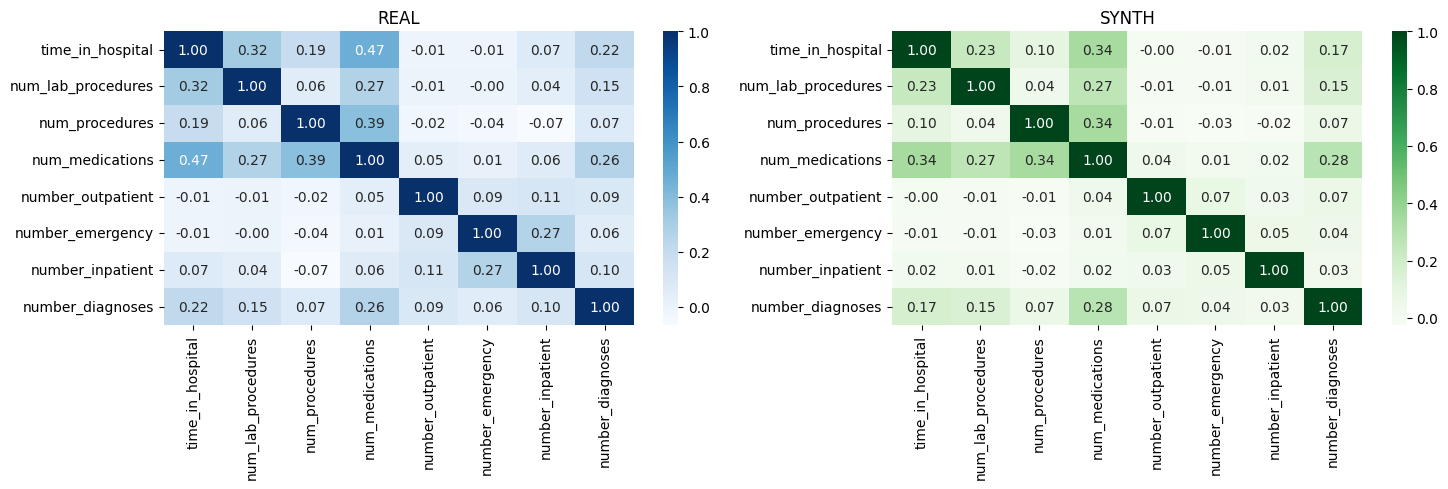

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# CORRELATION MATRIX
fig, ax = plt.subplots(1,2,figsize = (15,5))
corr_r = diabetes.corr()
corr_s = synthetic_data.corr()
sns.heatmap(corr_r, 
            xticklabels=corr_r.columns.values,
            yticklabels=corr_r.columns.values,
            cmap="Blues",
            annot=True,         # Display the correlation values in the cells
            fmt=".2f", ax = ax[0])
sns.heatmap(corr_s, 
            xticklabels=corr_s.columns.values,
            yticklabels=corr_s.columns.values,
            cmap="Greens",
            annot=True,         # Display the correlation values in the cells
            fmt=".2f", ax = ax[1])
ax[0].set_title("REAL")
ax[1].set_title("SYNTH")
plt.tight_layout()     
plt.show()